## 라이브러리 불러오기

In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from kiwipiepy import Kiwi
from bertopic import BERTopic
from umap import UMAP
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 데이터 불러오기

In [2]:
data_path = './data/뉴스_크롤링.xlsx'
df = pd.read_excel(data_path, index_col=False)

In [3]:
df

,Date,Title,Content
0,2023-11-27,[사설] 생활권 침해 없는데 봉안당 불허···님비에 법원 제동,극단적인 지역이기주의에 지역 현안들이 발목이 잡혀있는 가운데 법원이 과도한 님비현상...
1,2023-11-27,[전남일보]기고·김정화>지방소멸 대책 신안에 있다,김정화 신안군농업기술센터소장\n김정화 소장\n“바보야! 문제는 경제야!”(“It’s...
2,2023-11-27,“학생 수 감소했다면 학교용지비용 부담 필요 없어”,[KBS 광주]\n취학 인구가 감소했는데도 학교용지부담금을 부과한 행정처분은 부당하...
3,2023-11-27,서삼석 예결위원장 “올해 전 부처가 증액 요구…특활비 무조건 삭감보다 투명성 제고”...,서삼석 국회 예산결산특별위원회 위원장이 17일 오후 서울 여의도 국회에서 헤럴드경제...
4,2023-11-27,"경단녀서 꽃가게 사장님으로… ""지방은 기회의 공간"" [지방시대 지방영웅]",<4> 전남 목포 '두리하나 플라워' 임효백씨 아이 때문에 결심한 '지방살이'서 꿈...
...,...,...,...
4230,2021-01-03,'포스트 코로나 원년' 올해는 꼭 보여주고 싶 '소',■미리보는 2021 3대 비엔날레\n광주비엔날레에 전시되는 아나 마리아 밀란 작 '...
4231,2021-01-03,인사 종합,[인사]광주시\n◇3급 전보△자치행정국장 김일융 △공무원교육원장 김애리 △서구 부구...
4232,2021-01-03,"김종식 목포시장 ""호랑이눈·소 걸음으로 뚝심있게 계획 실행""","김종식 목포시장1\n김종식 목포시장은 신축년 새해를 맞아 시정 목표와 관련해 ""코로..."
4233,2021-01-02,[신년사] 김종식 목포시장,김종식 목포시장\n존경하는 시민 여러분! 그리고 동료 공직자 여러분! 2021년 새...


## 사용할 토크나이저 생성
- 한국어 형태소분석기인 kiwi 사용

In [4]:
class MyTokenizer:
    def __init__(self, kiwi):
        self.kiwi = kiwi
    def __call__(self, text):
        result = list()
        for token in self.kiwi.tokenize(text):
            if token[1] in ["NNG", "NNP", "NNB", "NR", "NP"] and int(token[3]) > 1:
                result.append(token[0])
        return result
    
mytokenizer = MyTokenizer(Kiwi())

## 단어 행렬 생성
- 불용어 불러오기

In [5]:
with open('./stopwords.txt', encoding= 'utf-8') as f:
    stopwords = []
    for w in f:
        stopwords.append(w.strip())

vectorizer =  CountVectorizer(tokenizer=mytokenizer, max_features=300, stop_words=stopwords)

## Bertopic parameters
- https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic

In [17]:
umap_model = UMAP(n_neighbors=15, n_components=5,
                  min_dist=0.0, metric='cosine', random_state=42)
model = BERTopic(embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
                 umap_model=umap_model,
                 vectorizer_model=vectorizer,
                 nr_topics=11,
                 top_n_words=10,
                 calculate_probabilities=True)

## BERTopic 실행
- fit: Bert, UMAP, HDBSCAN를 주어진 document에 맞추기
- fit_transform: 모델 맞추기, 토픽 생성, 문서별 확률 및 토픽 반환을 한번에 진행

In [18]:
topics, probs = model.fit_transform(df['Content'])

## 토픽별 단어 확인

In [19]:
model.get_topic(0)

[('교육', 0.0563234087979481),
 ('학교', 0.03192209146222924),
 ('학생', 0.029959475822037694),
 ('청년', 0.028565002202385087),
 ('제공', 0.0284698881171688),
 ('시설', 0.026888763762623474),
 ('조성', 0.026417457699957212),
 ('계획', 0.02637745233564891),
 ('대상', 0.026347561801621337),
 ('운영', 0.025443800420156062)]

## 전체 토픽 확인

In [20]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1552,-1_교육_주민_운영_추진,"[교육, 주민, 운영, 추진, 센터, 학교, 청년, 사회, 진행, 전국]",[다자간 MOU 체결… 민·관 상호협력체계 구축\n왼쪽부터 CJ올리브네트웍스 차인혁...
1,0,906,0_교육_학교_학생_청년,"[교육, 학교, 학생, 청년, 제공, 시설, 조성, 계획, 대상, 운영]","[1만2600명에 기초연금 지급\n신안군, 노인층 위한 식사배달.\n신안군은 65세..."
2,1,562,1_도시_시민_추진_교육,"[도시, 시민, 추진, 교육, 청소년, 청년, 문학, 대학, 산업, 운영]",[18일 목포시의회 임시회 민선8기 첫 시정연설\n박홍률 목포시장이 18일 제377...
3,2,338,2_후보_농협_선거_지방,"[후보, 농협, 선거, 지방, 산업, 발전, 대표, 교육, 농업, 군수]",[민선 7기 3주년 인터뷰…소회와 앞으로의 계획 밝혀\n김산 무안군수가 기자의 질문...
4,3,275,3_갯벌_해양_생물_환경,"[갯벌, 해양, 생물, 환경, 자원, 에너지, 생태, 세계, 유산, 양식]","[한국의 갯벌 전경. 해수부 제공\n◆‘갯벌 세계자연유산 보전본부’, 전남 신안에 ..."
5,4,140,4_관광_세계_마을_홍어,"[관광, 세계, 마을, 홍어, 축제, 갯벌, 전시, 체험, 우수, 프로그램]",[유엔세계관광기구는 2일 스페인 마드리드에서 총회를 열고 ‘유엔 세계 최우수 관광마...
6,5,137,5_지방_예산_소멸_인구,"[지방, 예산, 소멸, 인구, 재단, 지자체, 감소, 계획, 인재, 대응]",[2년간 국비 210억 원 등 총 329억 원 확보\n\n\n【파이낸셜뉴스 신안=황...
7,6,125,6_안전_점검_해양_학교,"[안전, 점검, 해양, 학교, 발생, 조사, 오전, 현장, 병원, 시설]",[[무안=아시아경제 호남취재본부 윤자민 기자] 전남도가 이태원 참사 수습을 위한 예...
8,7,124,7_인구_청년_감소_코로나,"[인구, 청년, 감소, 코로나, 수도, 전국, 병원, 발생, 소멸, 증가]",[목포시가 인구 감소 추세에 대응하고 인구 증가를 위해 분야별 대책 추진에 총력을 ...
9,8,61,8_근로자_인권_일자리_고용,"[근로자, 인권, 일자리, 고용, 조사, 기간, 공공, 기관, 농가, 관련]",[무안군과 필리핀 실랑시의 외국인 계절근로자 업무협약에 따라 최근 계절근로자 프로그...


## 토픽 병합

In [11]:
topics_to_merge = [3, 4]
model.merge_topics(df['Content'], topics_to_merge)

In [ ]:
model.get_topic_info()

## 토픽 클러스터링 시각화

In [21]:
model.visualize_topics(topics=list(range(10)))

In [30]:
for i in range(10):
    print(i,'번째 토픽 :', model.get_topic(i))

0 번째 토픽 : [('교육', 0.0563234087979481), ('학교', 0.03192209146222924), ('학생', 0.029959475822037694), ('청년', 0.028565002202385087), ('제공', 0.0284698881171688), ('시설', 0.026888763762623474), ('조성', 0.026417457699957212), ('계획', 0.02637745233564891), ('대상', 0.026347561801621337), ('운영', 0.025443800420156062)]
1 번째 토픽 : [('도시', 0.05230820930997778), ('시민', 0.04296787998655672), ('추진', 0.03628446906558567), ('교육', 0.033734213438951464), ('청소년', 0.03127557371028459), ('청년', 0.030780968386703737), ('문학', 0.030326661069215888), ('대학', 0.03003542731315398), ('산업', 0.02909337109449843), ('운영', 0.02883554234816563)]
2 번째 토픽 : [('후보', 0.0650621869388063), ('농협', 0.0475427200000514), ('선거', 0.04559851656840974), ('지방', 0.036822504889615366), ('산업', 0.03642882546491723), ('발전', 0.03523252271290288), ('대표', 0.03236878869581346), ('교육', 0.031492157755363834), ('농업', 0.030920318349046075), ('군수', 0.02949512903297861)]
3 번째 토픽 : [('갯벌', 0.07489838536519049), ('해양', 0.07177000675607), ('생물', 0.0496990312528

In [31]:
model.visualize_heatmap(topics=list(range(10)))

In [32]:
timestamps = df['Date'].to_list()
content_text = df['Content'].to_list()

topics_over_time = model.topics_over_time(content_text, timestamps)

2023-12-26 14:41:18,835 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 915) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


In [33]:
model.visualize_topics_over_time(topics_over_time, topics=list(range(10)))

In [34]:
model.visualize_topics_over_time(topics_over_time, topics=[0])

## 워드클라우드 생성

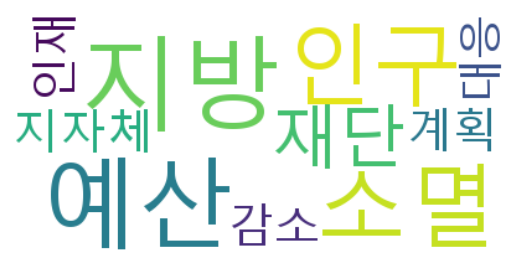

In [49]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, font_path="C:/Windows/Fonts/malgun.ttf")
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

create_wordcloud(model, topic=5)

## 문서 예측

In [47]:
with open('./data/new_docs.txt', encoding= 'utf-8') as f:
    test_doc = []
    for w in f:
        test_doc.append(w.strip())

print(test_doc)

['전라남도는 연말연시를 맞아 저소득 취약계층 5000여명에 수산물 꾸러미를 전달한다고 26일 밝혔다.', '재원은 해양수산부 수산물 꾸러미 지원사업 공모 선정으로 확보한 국비 1억 3000만원 등을 사용한다.', '수산물 꾸러미는 가정에서 요리하기 편한 대중적 수산물로, 건강까지 챙길 수 있는 굴비와 자숙 전복, 김, 미역, 자반 등 5만원 상당으로 구성됐다.', '지원 대상은 전남에 주민등록 주소를 둔 자활 참여자, 장애인 복지관 이용자, 장애인 주간 보호시설 이용자, 장애인 직업 재활시설 이용자 등 5306명이다. 27일부터 공급할 계획이다.', '김영록 전남지사는 "수산물 꾸러미 사업은 취약계층의 건강도 챙기고 수산물의 판로 확대로 어가 소득도 향상되는 일석이조 사업"이라며 "향후 사업을 확대해 다양한 계층에게 공급되도록 노력하겠다"고 말했다.']


In [48]:
topics, probs = model.transform([test_doc])
print('예측한 토픽 번호 :', topics)

예측한 토픽 번호 : [5]


## 모델 저장

In [58]:
model.save('bertopic_results', serialization='safetensors')

## 불러오기

In [59]:
BerTopic_model = BERTopic.load("bertopic_results")